# 2.4. Пример расчета поля давлений для нескольких скважин на стационарном режиме



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import scipy 

Базовая функция для расчета - расчет влияния одной скважины с постоянным дебитом в произвольной точке пласта. 
Самый простой вариант использует логарифмическое приближение

In [2]:
def dp_ss_atm(q_liq_sm3day = 50,
               mu_cP = 1,
               b_m3m3 = 1.2,
               kh_mDm = 40,
               r_e_m = 240,
               r_m = 0.1):
  """
  функция расчета перепада давления в произвольной точке пласта 
  на расстоянии r_m от центра скважины
  для стационарного решения уравнения фильтрации 
  q_liq_sm3day - дебит жидкости на поверхности в стандартных условиях
  mu_cP - вязкость нефти (в пластовых условиях)
  B_m3m3 - объемный коэффициент нефти 
  kh_mDm - kh пласта
  r_e_m - радиус контрура питания, м  
  r_m - расстояние на котором проводится расчет, м
  """
  return 18.41 * q_liq_sm3day * mu_cP * b_m3m3/ kh_mDm * np.log(r_e_m/r_m)


Класс для расчета влияния одной скважины
- объединяет все необходимые данные для скважины
- позволяет рассчитать депрессию и давления в любой точке пласта с учетом радиуса влияния и радиуса скважины

In [3]:
class Well:
    """
    класс Well описывает влияние одной скважины на поле давления
    используется стационарное решение
    """
    kh_mDm = 10.0
    b_m3m3 = 1.0
    mu_cP = 1.0
    skin = 0
    r_e_m = 250.0
    r_w_m = 0.1
    q_liq_sm3day = 10

    def __init__(self, name, xw_m, yw_m) -> None:
        self.x_m = xw_m
        self.y_m = yw_m
        self.name = name
        pass

    def calc_dp_ss_atm(self, x_m, y_m):
        """
        расчет перепада давления в произвольной точке пласта 
        с заданными координатами
        для стационарного решения уравнения фильтрации 
        x_m, y_m координаты в которых рассчитывается давление
        """

        r_m = np.sqrt( (self.x_m - x_m)**2 + (self.y_m - y_m)**2 )
        r_m = np.where(r_m >= self.r_e_m, self.r_e_m ,r_m)
        r_m = np.where(r_m < self.r_w_m, self.r_w_m ,r_m)

        return dp_ss_atm(q_liq_sm3day=self.q_liq_sm3day,
                          mu_cP=self.mu_cP,
                          b_m3m3=self.b_m3m3,
                          kh_mDm=self.kh_mDm,
                          r_e_m = self.r_e_m,
                          r_m = r_m)
    
    def calc_dp_ss_well_atm(self, w):
        return self.calc_dp_ss_atm(w.x_m, w.y_m)


    def calc_p_ss_atma(self, x_m, y_m, p_res_atma):
        """
        функция расчета давления в произвольной точке пласта 
        с заданными координатами
        для стационарного решения уравнения фильтрации 
        x_m, y_m координаты в которых рассчитывается давление
        """

        return p_res_atma - self.calc_dp_ss_atm(x_m, y_m)

In [4]:
class Wells:

    p_res_atma = 250

    def __init__(self, name:list, xw_m:list, yw_m:list, kh_mDm=10, b_m3m3=1, mu_cP=1, r_e_m =250, r_w_m=0.1) -> None:
        
        self.well_dict: dict[str, Well] = {} #
        
        for (n, x, y) in zip(name, xw_m, yw_m):
            self.well_dict.update({n: Well(n,x,y)})
        self.set_kh_mDm(kh_mDm)
        self.set_pvt(b_m3m3=b_m3m3, mu_cP=mu_cP)
        self.set_r_e_m(r_e_m)
        self.set_r_w_m(r_w_m)
    
    def set_qliq_sm3day(self, q_liq_list_sm3day:list):
        for (wname, q) in zip(self.well_dict, q_liq_list_sm3day):
            self.well_dict[wname].q_liq_sm3day = q
    
    def set_kh_mDm(self, kh_mDm):
        for wn in self.well_dict:
            self.well_dict[wn].kh_mDm = kh_mDm

    def set_r_e_m(self, r_e_m):
        for wn in self.well_dict:
            self.well_dict[wn].r_e_m = r_e_m
    
    def set_r_w_m(self, r_w_m):
        for wn in self.well_dict:
            self.well_dict[wn].r_w_m = r_w_m

    def set_pvt(self, mu_cP, b_m3m3):
        for wn in self.well_dict:
            self.well_dict[wn].b_m3m3 = b_m3m3
            self.well_dict[wn].u_cP = mu_cP

    def calc_p_ss_atma(self, x_m, y_m):
        dp = 0
        for wn in self.well_dict:
            dp = dp + self.well_dict[wn].calc_dp_ss_atm(x_m, y_m)
        return self.p_res_atma - dp

    def estimate_qliq_from_pwf(self, wn_list:list, pwf_list:list):
        dim = len(wn_list)  # размерность матрицы для расчета дебитов

        # создадим заготовки матрицы А и вектора В по формулам (4) и (5)
        A = np.zeros((dim,dim))
        B = np.zeros(dim)


        for i, wni in enumerate(wn_list):
            self.well_dict[wni].q_liq_sm3day = 1
            for j, wnj in enumerate(wn_list):
                A[i,j] = self.well_dict[wni].calc_dp_ss_well_atm(self.well_dict[wnj])
            B[i] = self.p_res_atma - pwf_list[i]
        
        q_list = scipy.linalg.solve(A,B)


        for i, wni in enumerate(wn_list):
            self.well_dict[wni].q_liq_sm3day = q_list[i]



In [17]:
xlist = [300, -300, 50]
ylist = [0, 0, 200]
names = ['1', '2', '3']
qlist = [10, -20, 10]

ww = Wells(names, xlist, ylist, r_e_m=500)
ww.set_qliq_sm3day(qlist)


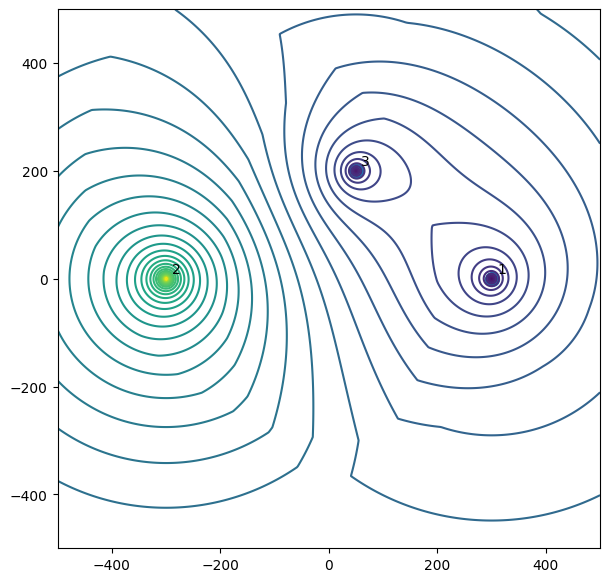

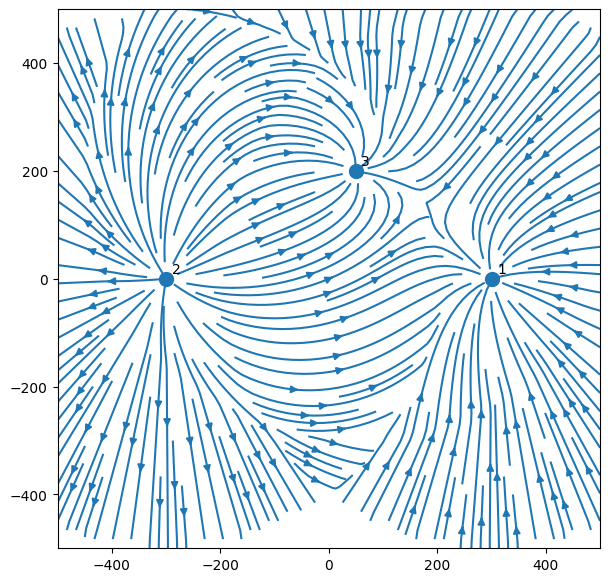

In [31]:
xp = np.linspace(-500, 500, 500)
yp = np.linspace(-500, 500, 500)

xv, yv = np.meshgrid(xp, yp)

p_mesh = ww.calc_p_ss_atma(xv, yv)


# построим отображение в виде контурной карты
plt.rcParams["figure.figsize"] = (7,7)
plt.contour(xp, yp, p_mesh, levels=50)
for x,y,n in zip(xlist, ylist, names):
    plt.text(x+10, y+10, n)
plt.scatter(xlist, ylist, s =100)
plt.show()

plt.rcParams["figure.figsize"] = (7,7)
plt.streamplot(xp, yp, -np.gradient(p_mesh,axis=1), -np.gradient(p_mesh,axis=0), density=2)
for x,y,n in zip(xlist, ylist, names):
    plt.text(x+10, y+10, n)
plt.scatter(xlist, ylist, s =100)
plt.show()

# Решение для заданных забойных давлений

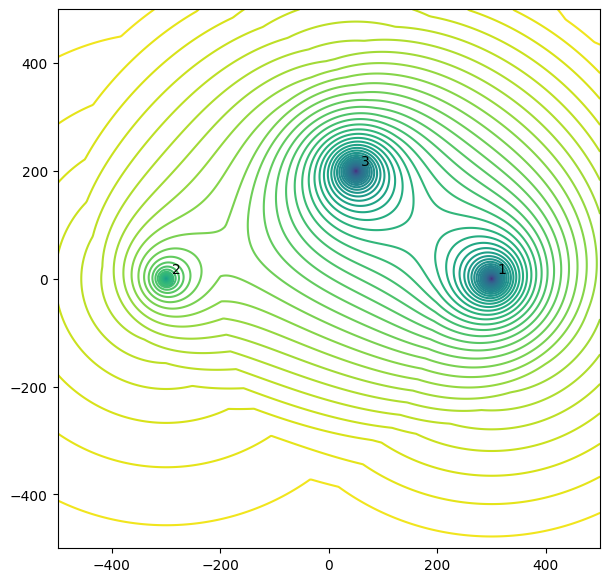

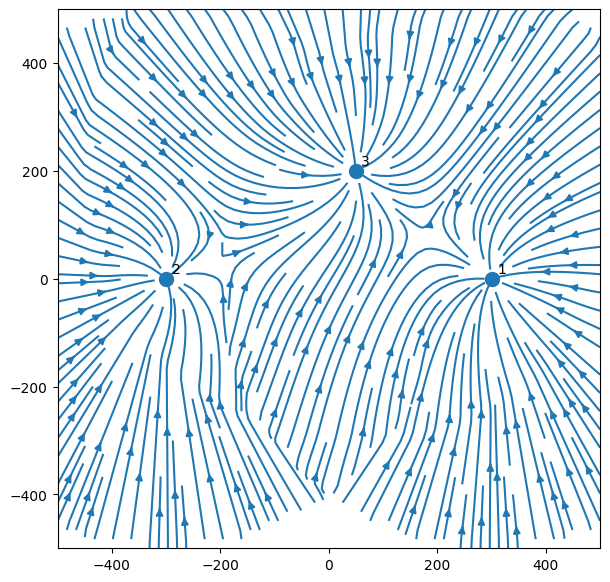

In [32]:
xlist = [300, -300, 50]
ylist = [0, 0, 200]
names = ['1', '2', '3']
qlist = [10, -20, 10]
plist = [50, 150, 50]

ww = Wells(names, xlist, ylist, r_e_m=500)
ww.estimate_qliq_from_pwf(names, plist)

xp = np.linspace(-500, 500, 500)
yp = np.linspace(-500, 500, 500)

xv, yv = np.meshgrid(xp, yp)

p_mesh = ww.calc_p_ss_atma(xv, yv)


# построим отображение в виде контурной карты
plt.rcParams["figure.figsize"] = (7,7)
plt.contour(xp, yp, p_mesh, levels=50)
for x,y,n in zip(xlist, ylist, names):
    plt.text(x+10, y+10, n)
plt.scatter(xlist, ylist, s =100)
plt.show()

plt.rcParams["figure.figsize"] = (7,7)
plt.streamplot(xp, yp, -np.gradient(p_mesh,axis=1), -np.gradient(p_mesh,axis=0), density=2)
for x,y,n in zip(xlist, ylist, names):
    plt.text(x+10, y+10, n)
plt.scatter(xlist, ylist, s =100)
plt.show()